# *Imports*

In [71]:
%matplotlib inline

In [72]:
!pip install dask==2.20

import sys
from time import time


from dask.distributed import Client, progress

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from dask import delayed
import dask
from skimage.color import rgb2gray

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
# from google.colab import drive
# drive.mount('/content/drive')

# from "/content/drive/My Drive" import commonfunctions as cf 

from skimage.color import rgb2gray
import cv2
import os


<hr>
<hr>

# *Modules to read/show images (folder/webcam)*

In [141]:
def read_img_from_webcam():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
#             cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1
            break

    cam.release()

    cv2.destroyAllWindows()
    frame = rgb2gray(frame)
#     print(frame.shape)
#     (480, 640)

#     height = frame.shape[0]
#     width = frame.shape[1]
#     new_height =  250
#     new_width = int((new_height * width) / height)
#     frame = cv2.resize(frame,(new_width,new_height))
    
    frame = frame[115:115+250,195:195+250]
    print(frame.shape)
    return frame

In [74]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [75]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(rgb2gray(img))
    return images

In [76]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

<hr>
<hr>

# *Reading Data*

In [77]:
images = lfw_subset()
print(len(images))

200


In [78]:
# I tried to make my own non-face images but it gave really bad accuracy since it was from webcam
# and was huge in size compared to 25X25 in train

# images = []
# non_face_train_dir = r'D:\Uni\Semester 9\Image\Project\Face detection\Haar basics\final_cropped_non_faces_training'
# for filename in os.listdir(non_face_train_dir):
#   img = cv2.imread(os.path.join(non_face_train_dir,filename))
#   if img is not None:
#     resized = cv2.resize(img,(200,200))
#     images.append(rgb2gray(resized))
    
# train_data_diroctry = '/content/drive/My Drive/new_train_data'
train_data_diroctry = '/content/drive/MyDrive/final_train_data'
train_data_diroctry = r'D:\Uni\Semester 9\Image\Project\Saved\5 after meeting 2\final_cropped_training'


images_read = []
for filename in os.listdir(train_data_diroctry):
  img = cv2.imread(os.path.join(train_data_diroctry,filename))
  if img is not None:
    resized = cv2.resize(img,(200,200))
    images_read.append(rgb2gray(resized))

# new_images = np.asarray([cv2.resize(images[i],(200,200)) for i in range(100)])
new_images = np.asarray([cv2.resize(images[i],(200,200)) for i in range(100,200)])
images_read = np.asarray(images_read)
images_read = np.append(images_read,new_images,axis=0)

print(images_read.shape)

(200, 200, 200)


In [79]:
images = np.asarray([cv2.resize(images_read[i,:,:],(25,25)) for i in range(0,200)])
print(images.shape)

(200, 25, 25)


<hr>
<hr>

# *Training*

### Splitting data -> train-test

In [80]:
images = np.asarray([cv2.resize(images_read[i,:,:],(25,25)) for i in range(0,200)])
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_full_feature_comp = time() - t_start

# Label images (100 faces and 100 non-faces)
y = np.array([1] * 100 + [0] * 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)
print(images.shape)
# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

(200, 25, 25)


### Making an object from the classifier to get features importance  (Random forest classifier)

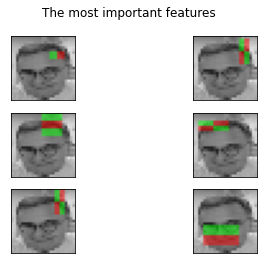

In [81]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

### Sorting features on importance to work only on the features that represent 70% of the whole features
#### Compared to the whole features number that is much less than them approx (0.6%) of the whole features number

In [82]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)

print("all features count: "+str(len(cdf_feature_importances)))
print("sig. features count: "+str(sig_feature_count))
# print("%: "+str(sig_feature_count/len(cdf_feature_importances)*100))

sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print((f'{sig_feature_count} features, or {sig_feature_percent}%, '
       f'account for 70% of branch points in the random forest.'))

# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_subs_feature_comp = time() - t_start

y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

all features count: 190224
sig. features count: 1155
1155 features, or 0.6%, account for 70% of branch points in the random forest.


In [83]:
np.max(cdf_feature_importances)
cdf_feature_importances

array([0.00272881, 0.00467792, 0.00654485, ..., 1.        , 1.        ,
       1.        ])

### Training model (Random Forest Classifier)

In [84]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

summary = ((f'Computing the full feature set took '
            f'{time_full_feature_comp:.3f}s, '
            f'plus {time_full_train:.3f}s training, '
            f'for an AUC of {auc_full_features:.2f}. '
            f'Computing the restricted feature set took '
            f'{time_subs_feature_comp:.3f}s, plus {time_subs_train:.3f}s '
            f'training, for an AUC of {auc_subs_features:.2f}.'))
print(summary)
plt.show()

Computing the full feature set took 140.067s, plus 2.774s training, for an AUC of 1.00. Computing the restricted feature set took 0.240s, plus 1.926s training, for an AUC of 1.00.


## Testing model on test and train data

In [85]:
t_start = time()
predicted_train = clf.predict(X_train)
time_subs_train = time() - t_start

print(time_subs_train)
# print(X_test.shape)
predicted_test = clf.predict(X_test)

predicted_train_acc = np.count_nonzero(predicted_train == y_train)
predicted_test_acc = np.count_nonzero(predicted_test == y_test)

# print(predicted_train)
# print(y_train)
# print(predicted_test)
# print(y_test)
print("train %: "+str(predicted_train_acc/len(y_train)*100))
print("test %: "+str(predicted_test_acc/len(y_test)*100))


0.15368199348449707
train %: 100.0
test %: 100.0


<hr>
<hr>

# *Testing*

## Loading and showing test images
### (never seen by the model neither on test nor train)

In [86]:
# images =load_images_from_folder('/content/drive/My Drive/Image_images') 
images =load_images_from_folder(r'D:\Uni\Semester 9\Image\Project\Saved\5 after meeting 2\Images') 


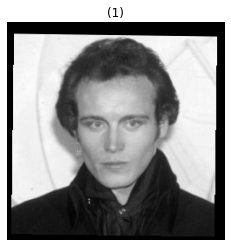

25
(250, 250)


In [87]:
img = images[12]

show_images([img])
print(len(images))
print(img.shape)

#### Testing how to show boundry box

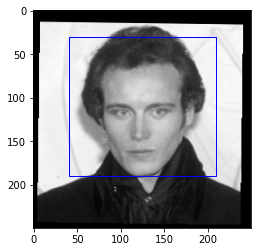

In [88]:
fig, axes = plt.subplots(1, 1)
image = np.copy(img)
axes.imshow(image)
rect = patches.Rectangle((40,30),170,160, edgecolor='b', facecolor="none") # 130X130
# rect = patches.Rectangle((10,80),50,160, edgecolor='b', facecolor="none")
axes.add_patch(rect)

## Testing to see cropping and resizing image would affect the image itself

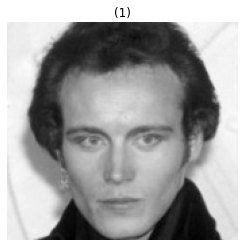

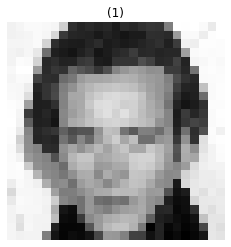

(25, 25)


In [89]:
test_img = image[30:191,40:211]
# test_img = image[80:241,10:61]
show_images([test_img])
resized_test_img = cv2.resize(test_img,(25,25))
show_images([resized_test_img])
print(resized_test_img.shape)

## Testing to predict a singe cropped image
#### [1]: Contains face, [0]: Does not contain face

In [90]:


ii = integral_image(resized_test_img)
temp_test = haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type_sel,
                             feature_coord=feature_coord_sel)
temp_test = np.reshape(temp_test,(1,-1))

print(temp_test.shape)
predicted_test_img = clf.predict(temp_test)
print(predicted_test_img)

(1, 1155)
[1]


<hr>
<hr>


#  __*Face Detection*__ (*Main module*)

## This function returns X1,Y1,X2,Y2 which is the upper left point and lower right point respc. of the bounding box for the face in the given image 

In [142]:
def get_face_bounding_box(input_img, print_window_times = True, print_frame_times = False, lower_window_range = 140, upper_window_range = 170, window_steps = 5, pixel_steps = 5, min_boxes_thr = 3,ratio = (2.3/3), show_frames = False, show_boxes = True, show_bounding = True):
  run_img = np.copy(input_img)
  width = run_img.shape[1]
  height = run_img.shape[0]

  boxes = [] # (x1,y1,x2,y2)
  for window_height in range(lower_window_range,upper_window_range,window_steps):
    window_start = time()
    window_width = int((ratio)*window_height)
    number_of_col_iters = width - window_width +1
    # print(number_of_col_iters)
    number_of_row_iters = height - window_height +1
    # print(number_of_row_iters)
    for i in range(0,number_of_row_iters,pixel_steps):
        for j in range(0,number_of_col_iters,pixel_steps):
            frame_start = time()
            window = run_img[ i:(i+window_height) , (j):(j+window_width)]
            # ii = integral_image(window)
            ii = integral_image(cv2.resize(window,(25,25)))
            temp_test = haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                                        feature_type=feature_type_sel,
                                        feature_coord=feature_coord_sel)
            temp_test = np.reshape(temp_test,(1,-1))
            predicted_test_img = clf.predict(temp_test)
            if(predicted_test_img):
              boxes.append((j,i,j+window_width,i+window_height))
              if show_frames:
                show_images([window])
            if print_frame_times:
              print("1 window on one frame: "+str(time() - frame_start))

    if print_window_times:
      print("1 window size time along the whole image: "+str(time() - window_start))

  if show_boxes:
    fig, axes = plt.subplots(1, 1)
    image = np.copy(run_img)
    axes.imshow(image)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='b', facecolor="none") # 130X130
        axes.add_patch(rect)
    plt.show()

  boxes = np.asarray(boxes)
  n = boxes.shape[0]
  avrg_x1, avrg_y1, avrg_x2, avrg_y2 = 0, 0, 0, 0
  if(len(boxes)>min_boxes_thr):
    avrg_x1 = np.sum(boxes[:,0]) / n
    avrg_y1 = np.sum(boxes[:,1]) / n
    avrg_x2 = np.sum(boxes[:,2]) / n
    avrg_y2 = np.sum(boxes[:,3]) / n

  if show_bounding:
    fig, axes = plt.subplots(1, 1)
    image = np.copy(run_img)
    axes.imshow(image)
    rect = patches.Rectangle((avrg_x1,avrg_y1),avrg_x2-avrg_x1,avrg_y2-avrg_y1, edgecolor='b', facecolor="none") 
    axes.add_patch(rect)

    plt.show()
    print("Number of boxes detected: "+str(len(boxes)))
  return avrg_x1, avrg_y1, avrg_x2, avrg_y2


## Function testing on single and many images

1 window size time along the whole image: 3.4403820037841797
1 window size time along the whole image: 2.9158754348754883


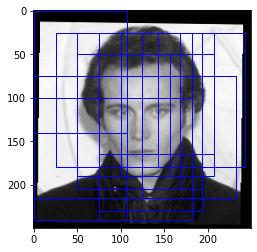

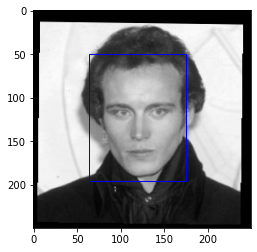

Number of boxes detected: 18


(63.888888888888886, 50.0, 175.16666666666666, 195.83333333333334)

In [93]:
get_face_bounding_box(img,window_steps=15,pixel_steps=25)

1 window size time along the whole image: 2.470323085784912
1 window size time along the whole image: 2.261636972427368


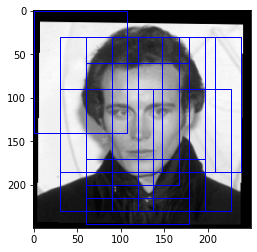

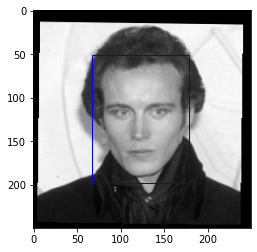

Number of boxes detected: 13


(66.92307692307692, 50.76923076923077, 179.0, 197.69230769230768)

In [94]:
new_img = images[12]
get_face_bounding_box(new_img,window_steps=15,pixel_steps=30)

1 window size time along the whole image: 3.5677335262298584
1 window size time along the whole image: 2.8101606369018555


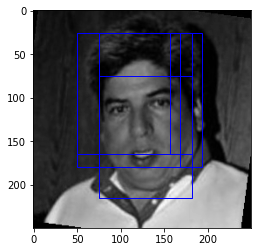

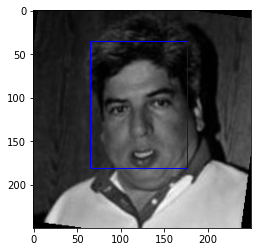

Number of boxes detected: 5


(65.0, 35.0, 176.4, 181.0)

In [95]:
new_img = images[5]
get_face_bounding_box(new_img,window_steps=15,pixel_steps=25)

1 window size time along the whole image: 3.5084640979766846
1 window size time along the whole image: 3.0529587268829346


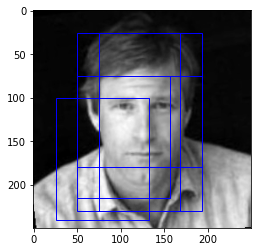

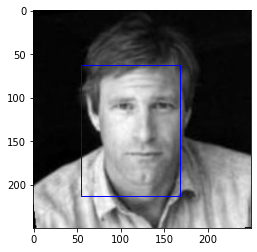

Number of boxes detected: 6
1 window size time along the whole image: 3.8254077434539795
1 window size time along the whole image: 3.122302293777466


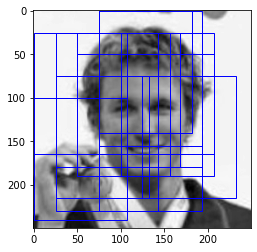

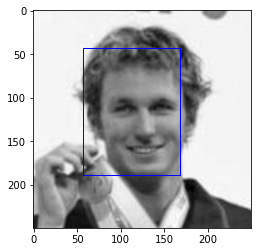

Number of boxes detected: 15
1 window size time along the whole image: 4.05141019821167
1 window size time along the whole image: 2.9798011779785156


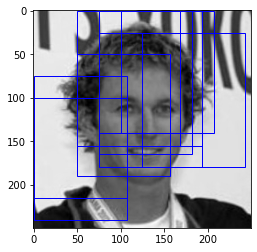

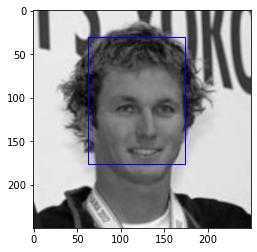

Number of boxes detected: 10
1 window size time along the whole image: 3.5494225025177
1 window size time along the whole image: 3.028822422027588


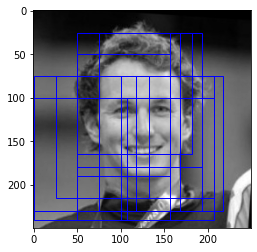

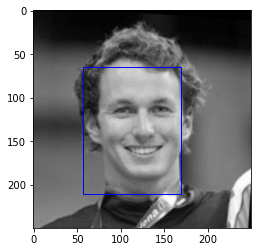

Number of boxes detected: 14
1 window size time along the whole image: 3.772418260574341
1 window size time along the whole image: 2.9632766246795654


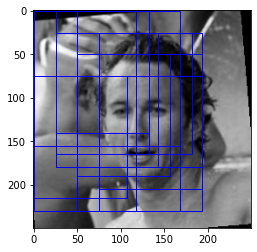

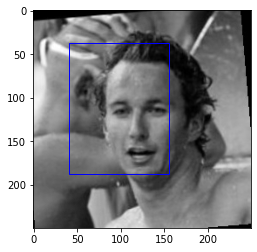

Number of boxes detected: 14
1 window size time along the whole image: 3.9119651317596436
1 window size time along the whole image: 3.1457855701446533


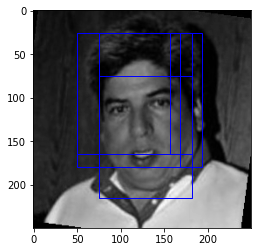

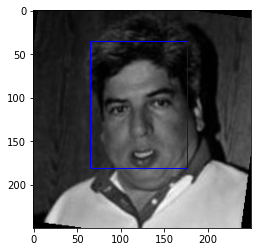

Number of boxes detected: 5
1 window size time along the whole image: 4.078431844711304
1 window size time along the whole image: 2.893716812133789


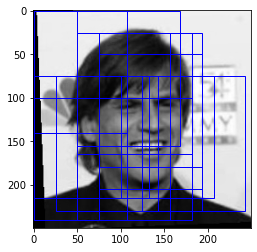

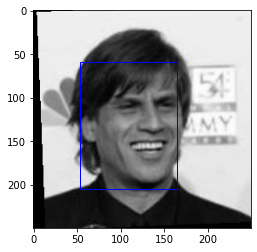

Number of boxes detected: 15
1 window size time along the whole image: 3.694136381149292
1 window size time along the whole image: 2.843564033508301


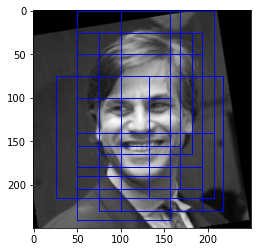

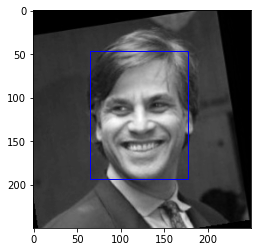

Number of boxes detected: 15
1 window size time along the whole image: 3.7534430027008057
1 window size time along the whole image: 2.8042995929718018


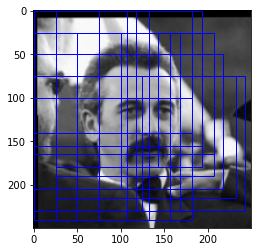

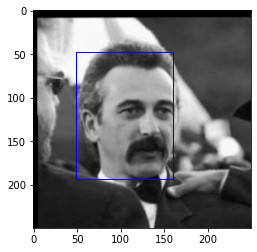

Number of boxes detected: 24
1 window size time along the whole image: 3.774561643600464
1 window size time along the whole image: 2.8104398250579834


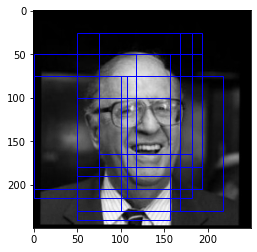

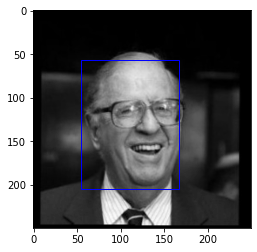

Number of boxes detected: 11
1 window size time along the whole image: 3.8399314880371094
1 window size time along the whole image: 2.940133810043335


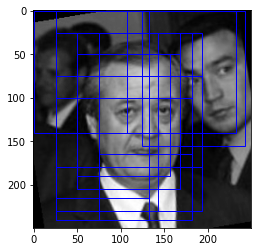

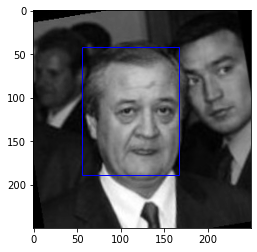

Number of boxes detected: 15
1 window size time along the whole image: 3.7516393661499023
1 window size time along the whole image: 3.253093719482422


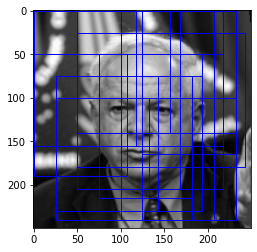

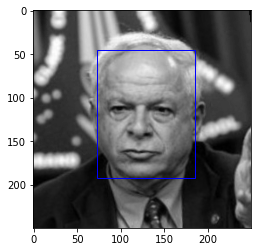

Number of boxes detected: 20
1 window size time along the whole image: 3.8314051628112793
1 window size time along the whole image: 2.851278781890869


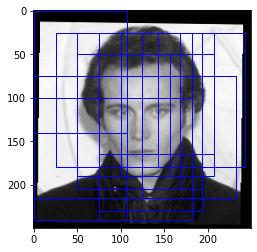

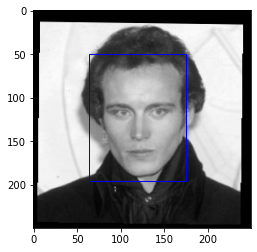

Number of boxes detected: 18
1 window size time along the whole image: 3.453639507293701
1 window size time along the whole image: 3.0088274478912354


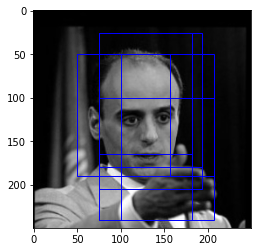

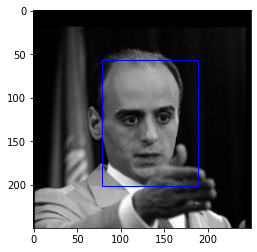

Number of boxes detected: 7
1 window size time along the whole image: 4.070413827896118
1 window size time along the whole image: 3.0302810668945312


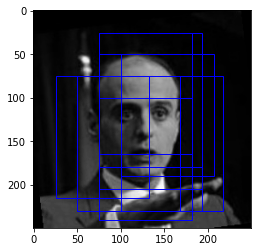

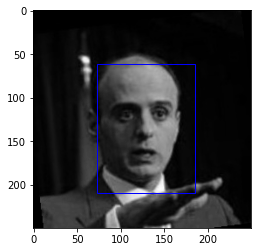

Number of boxes detected: 9
1 window size time along the whole image: 4.1120758056640625
1 window size time along the whole image: 3.8366713523864746


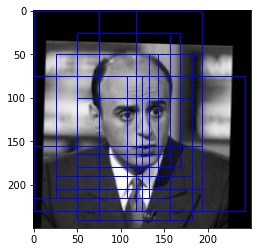

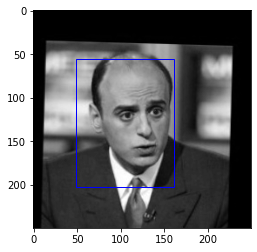

Number of boxes detected: 17
1 window size time along the whole image: 3.8077969551086426
1 window size time along the whole image: 3.170621156692505


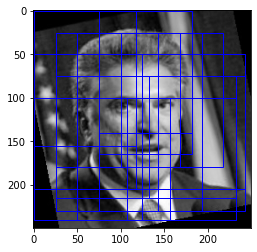

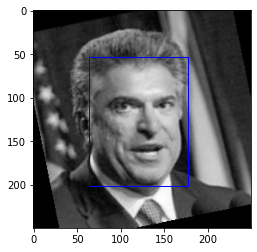

Number of boxes detected: 18
1 window size time along the whole image: 3.7765774726867676
1 window size time along the whole image: 3.0586535930633545


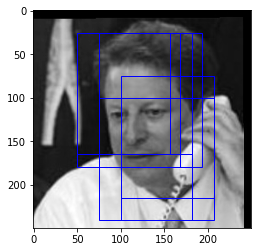

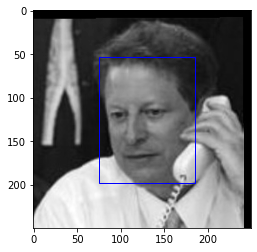

Number of boxes detected: 7
1 window size time along the whole image: 3.6781272888183594
1 window size time along the whole image: 2.851104497909546


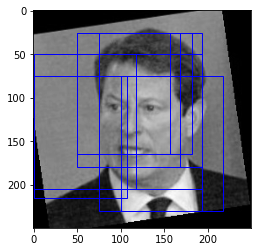

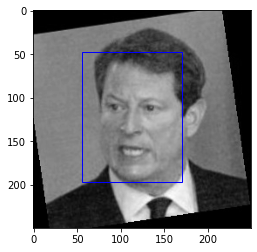

Number of boxes detected: 9
1 window size time along the whole image: 3.537468433380127
1 window size time along the whole image: 3.099709987640381


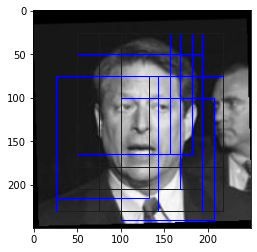

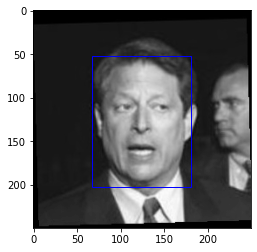

Number of boxes detected: 12
1 window size time along the whole image: 3.728379249572754
1 window size time along the whole image: 3.0457875728607178


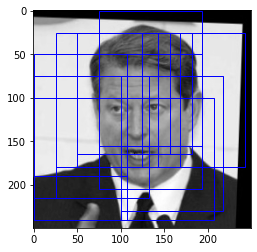

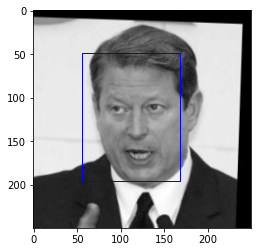

Number of boxes detected: 14
1 window size time along the whole image: 3.840529203414917
1 window size time along the whole image: 2.7594218254089355


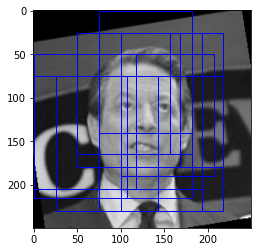

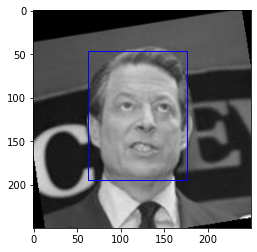

Number of boxes detected: 14
1 window size time along the whole image: 3.835430860519409
1 window size time along the whole image: 2.815397262573242


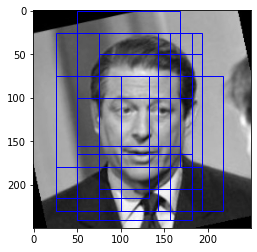

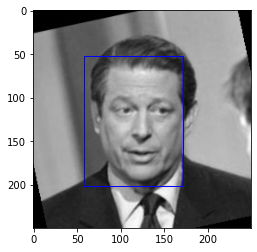

Number of boxes detected: 13
1 window size time along the whole image: 3.6894826889038086
1 window size time along the whole image: 2.881941318511963


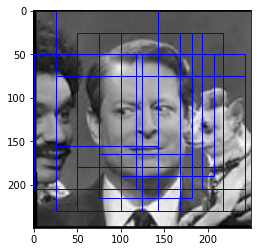

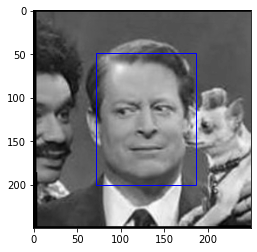

Number of boxes detected: 14
1 window size time along the whole image: 3.788252115249634
1 window size time along the whole image: 2.8340132236480713


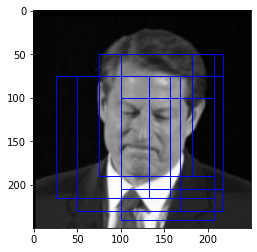

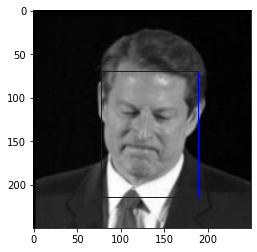

Number of boxes detected: 9


In [26]:
for new_img in images:
  get_face_bounding_box(new_img,window_steps=15,pixel_steps=25,show_boxes=True)

<hr>
<hr>

# *Trial for multithreading*

In [ ]:
# def compute_one_window(input_img, window_height, print_window_times = True, print_frame_times = False, pixel_steps = 25,ratio = (2.3/3), show_frames = False, show_boxes = True):
#   boxes = []
#   run_img = np.copy(input_img)
#   width = run_img.shape[1]
#   height = run_img.shape[0]

#   window_start = time()
#   window_width = int((ratio)*window_height)
#   number_of_col_iters = width - window_width +1
#   # print(number_of_col_iters)
#   number_of_row_iters = height - window_height +1
#   # print(number_of_row_iters)
#   for i in range(0,number_of_row_iters,pixel_steps):
#       for j in range(0,number_of_col_iters,pixel_steps):
#           frame_start = time()
#           window = run_img[ i:(i+window_height) , (j):(j+window_width)]
#           # ii = integral_image(window)
#           ii = integral_image(cv2.resize(window,(25,25)))
#           temp_test = haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
#                                       feature_type=feature_type_sel,
#                                       feature_coord=feature_coord_sel)
#           temp_test = np.reshape(temp_test,(1,-1))
#           predicted_test_img = clf.predict(temp_test)
#           if(predicted_test_img):
#             boxes.append((j,i,j+window_width,i+window_height))
#             if show_frames:
#               show_images([window])
#           if print_frame_times:
#             print("1 window on one frame: "+str(time() - frame_start))

#   if print_window_times:
#     print("1 window size time along the whole image: "+str(time() - window_start))
#   return boxes

In [ ]:
# def run_code():  
#   client = Client(threads_per_worker=4, n_workers=1)
#   client

#   new_img = np.copy(images[12])
#   show_images([new_img])
#   x = client.submit(compute_one_window, new_img,140)
#   y = client.submit(compute_one_window, new_img,155)
#   z = client.submit(compute_one_window, new_img,170)

#   x_ = x.result()
#   y_ = y.result()
#   z_ = z.result()

#   x_.append(y_)
#   x_.append(z_)

  
#   boxes = np.asarray(x_)
#   n = boxes.shape[0]
#   avrg_x1, avrg_y1, avrg_x2, avrg_y2 = 0, 0, 0, 0
#   print(boxes.shape)
#   if(len(boxes)):
#     avrg_x1 = np.sum(boxes[:][0]) / n
#     avrg_y1 = np.sum(boxes[:][1]) / n
#     avrg_x2 = np.sum(boxes[:][2]) / n
#     avrg_y2 = np.sum(boxes[:][3]) / n
    
# #   if show_bounding:
#   if True:
#     fig, axes = plt.subplots(1, 1)
#     image = np.copy(new_img)
#     axes.imshow(image)
#     rect = patches.Rectangle((avrg_x1,avrg_y1),avrg_x2-avrg_x1,avrg_y2-avrg_y1, edgecolor='b', facecolor="none") 
#     axes.add_patch(rect)

#     plt.show()
# if __name__ == "__main__":
#     run_code()

<br>
<br>

***

# *Webcam Testing*
##  with different images that contain and does not contain face

### First reading images from webcam
### <font color='red'>Note: when taking an image try to center your face on webcam due to cropping the webcam image </font> 

opencv_frame_0.png written!
(251, 251)
(251, 251)


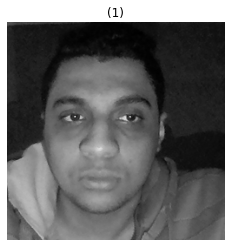

In [100]:
webcam_1 = read_img_from_webcam()
print(webcam_1.shape)
show_images([webcam_1])

opencv_frame_0.png written!
(251, 251)
(251, 251)


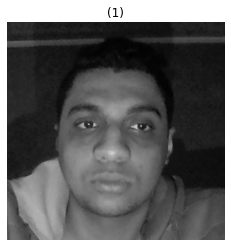

In [101]:
webcam_2 = read_img_from_webcam()
print(webcam_2.shape)
show_images([webcam_2])

opencv_frame_0.png written!
(251, 251)
(251, 251)


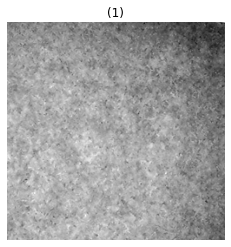

In [136]:
webcam_3 = read_img_from_webcam()
print(webcam_3.shape)
show_images([webcam_3])

opencv_frame_0.png written!
(251, 251)
(251, 251)


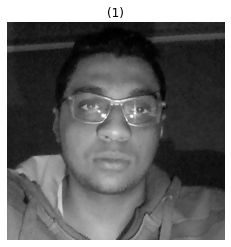

In [132]:
webcam_4 = read_img_from_webcam()
print(webcam_4.shape)
show_images([webcam_4])

opencv_frame_0.png written!
(251, 251)
(251, 251)


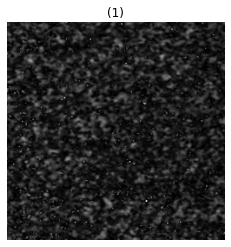

In [104]:
webcam_5 = read_img_from_webcam()
print(webcam_5.shape)
show_images([webcam_5])

opencv_frame_0.png written!
(251, 251)
(251, 251)


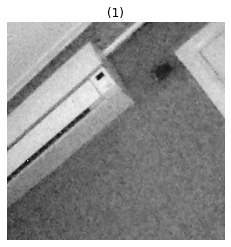

In [137]:
webcam_6 = read_img_from_webcam()
print(webcam_6.shape)
show_images([webcam_6])

### Showing all images that were took from webcam

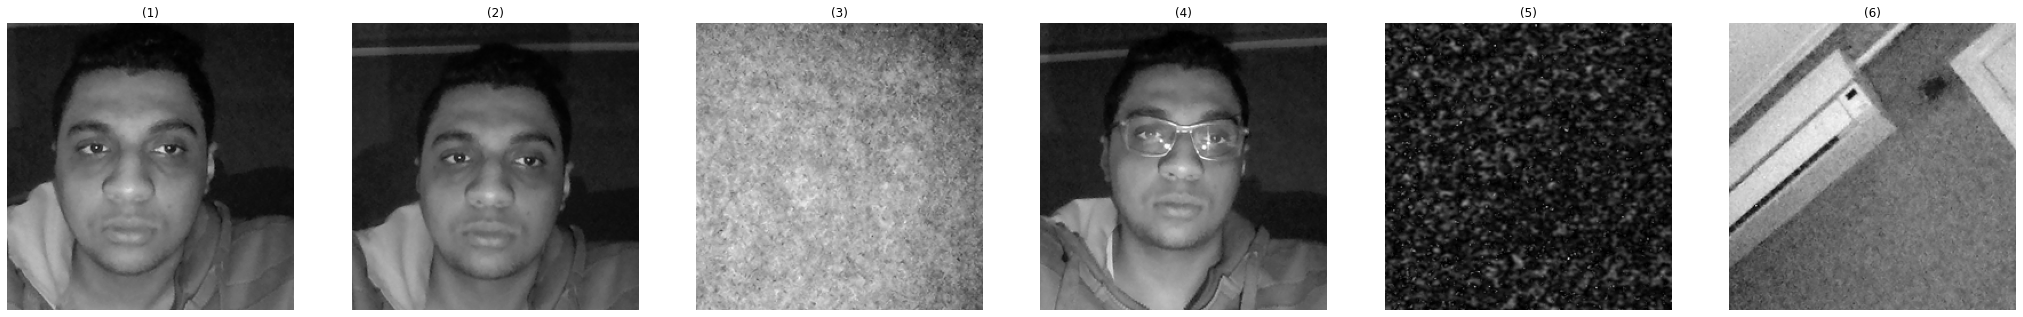

In [138]:
show_images([webcam_1,webcam_2,webcam_3,webcam_4,webcam_5,webcam_6])

### Testing on each image one by one

1 window size time along the whole image: 1.818436622619629
1 window size time along the whole image: 2.0958454608917236
1 window size time along the whole image: 0.8990099430084229


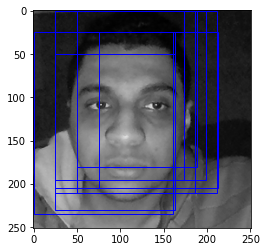

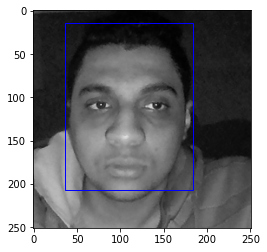

Number of boxes detected: 9


(36.111111111111114, 13.88888888888889, 184.22222222222223, 207.22222222222223)

In [128]:
get_face_bounding_box(webcam_1,lower_window_range=180,upper_window_range=220,window_steps=15,pixel_steps=25,show_boxes=True)

1 window size time along the whole image: 1.724308967590332
1 window size time along the whole image: 1.8440756797790527
1 window size time along the whole image: 0.8889572620391846


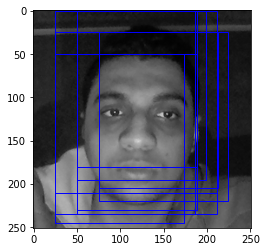

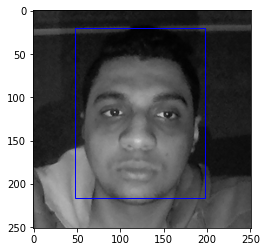

Number of boxes detected: 10


(47.5, 20.0, 198.0, 216.5)

In [126]:
get_face_bounding_box(webcam_2,lower_window_range=180,upper_window_range=220,window_steps=15,pixel_steps=25,show_boxes=True)

1 window size time along the whole image: 1.9419105052947998
1 window size time along the whole image: 1.8184070587158203
1 window size time along the whole image: 1.3402845859527588


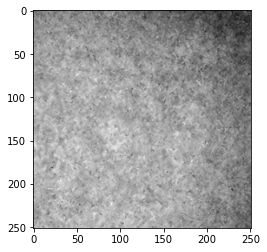

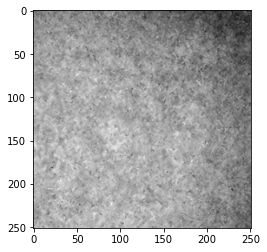

Number of boxes detected: 0


(0, 0, 0, 0)

In [140]:
get_face_bounding_box(webcam_3,lower_window_range=180,upper_window_range=220,window_steps=15,pixel_steps=25,show_boxes=True)

1 window size time along the whole image: 1.9799416065216064
1 window size time along the whole image: 1.8560361862182617
1 window size time along the whole image: 0.9493379592895508


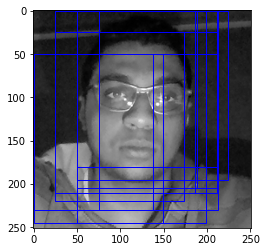

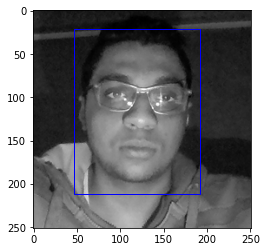

Number of boxes detected: 13


(46.15384615384615, 21.153846153846153, 191.92307692307693, 211.53846153846155)

In [134]:
get_face_bounding_box(webcam_4,lower_window_range=180,upper_window_range=220,window_steps=15,pixel_steps=25,show_boxes=True)

1 window size time along the whole image: 1.8048570156097412
1 window size time along the whole image: 1.717874526977539
1 window size time along the whole image: 0.9258322715759277


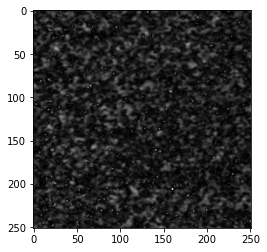

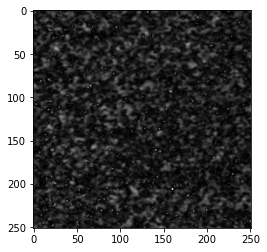

Number of boxes detected: 0


(0, 0, 0, 0)

In [131]:
get_face_bounding_box(webcam_5,lower_window_range=180,upper_window_range=220,window_steps=15,pixel_steps=25,show_boxes=True)

1 window size time along the whole image: 1.9342803955078125
1 window size time along the whole image: 1.694528579711914
1 window size time along the whole image: 0.8764619827270508


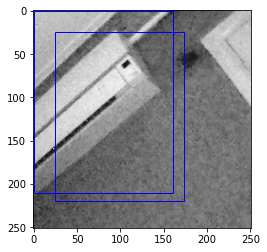

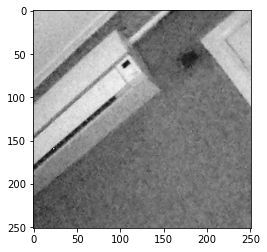

Number of boxes detected: 2


(0, 0, 0, 0)

In [139]:
get_face_bounding_box(webcam_6,lower_window_range=180,upper_window_range=220,window_steps=15,pixel_steps=25,show_boxes=True)